<a href="https://colab.research.google.com/github/ptmdmusique/cs510-data-with-python/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What Da Music

**Author**: Duc Phan

**Course**: CS 510; Data with Python - Summer 2025



## Description

- Analyze and learn about music created over the years
- Predict next year trend (TBD)

## Target questions

* What's the distribution of different genre and other interesting columns?
* Is there a correlation between popularity and other columns: play count, tempo, valence?
* Do the most repeated songs fall into a specific mood cluster (grouped by valence)?
* How do moods differ between genres (e.g.: rap vs classical)?
* What's the tempo, liveness, and valence over the year (e.g.: based on genre)?

## 1. Data fetching

Fetch data from Hugging Face. The sources are inside the cell itself.
There are 2 dataset that will be used for this project
* Detail song dataset - [link](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset) - contains information such as the liveliness, popularity, etc of the songs - **114k** rows
* Song metadata dataset - [link](https://huggingface.co/datasets/bigdata-pw/Spotify) - contains songs' metadata such as published year - **20M+** rows
(Seems like the data is deleted from the source)

However, to avoid rate limiting, the data loaded from a local csv and a zip folder instead. You can also skip to the cell where we download the `merged_df` directly as the data combining and cleaning can take hours‼

In [ ]:
import pandas as pd
import dask.dataframe as dd
!pip install -q gdown
import gdown
import ast
import matplotlib.pyplot as plt
import seaborn as sns
!pip install circlify
import circlify
import numpy as np
!pip install pycountry
import pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.1 MB/s eta 0:00:00


In [ ]:
# Load from dataset
# main_df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

# Load locally
gdown.download("https://drive.google.com/uc?id=17of8pv_Al00Er66cewY57NAu9BSDIvHy", "main_data.csv", quiet=False)
main_df = pd.read_csv("main_data.csv")
main_df.head()

Downloading...
From: https://drive.google.com/uc?id=17of8pv_Al00Er66cewY57NAu9BSDIvHy
To: /content/main_data.csv
100%|██████████| 20.1M/20.1M [00:00<00:00, 31.7MB/s]


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [ ]:
# Load from dataset
# metadata_df = dd.read_parquet("hf://datasets/bigdata-pw/Spotify/**/*.parquet")

# Load locally
gdown.download("https://drive.google.com/uc?id=1zOK8dgeKFkAOB1XfvPHQXIumJHQ-Mwxg", "metadata.zip", quiet=False)
!unzip metadata.zip -d metadata
metadata_df = dd.read_csv("metadata/metadata/metadata_*.csv")

metadata_df.head()

,album_name,album_uri,album_date,artists,content_rating,duration,language,name,playcount,popularity,uri
0,Glazunov: Symphony No. 1 & Violin Concerto,6UuhdubAi7oWtZe8uK2hwP,"{'day': 1.0, 'month': 9.0, 'year': 1999.0}",[{'artist_gid': 'ea7c8f0f20304977805a2a06d305b...,NONE,677440.0,['zxx'],"Violin Concerto in A Minor, Op. 82: II. Andante",0.0,1.0,00qxNz44liU0GuNvU6jK3S
1,Mississippi,1F0vVZSBGEwQCQLpMNAoX8,"{'day': 11.0, 'month': 8.0, 'year': 2023.0}",[{'artist_gid': 'ea8667fa63fd40919571ff6702463...,NONE,184514.0,['en'],Whistle,18327.0,17.0,7tMBIFLRHcwiwFSqTGr4nm
2,From Our Heart,5WRdAyymmUO5HTsXVd7Ki9,"{'day': 11.0, 'month': 8.0, 'year': 1988.0}",[{'artist_gid': 'ff2ec8aa0d6c461bb97aadf34655f...,NONE,177476.0,['en'],Jerusalem Coming Down,0.0,0.0,1Y126hnIT64R1nbqRiHGjY
3,Thunder Meditation,2N37AZizDFyq8uT1HqpIbt,"{'day': 23.0, 'month': 11.0, 'year': 2018.0}",[{'artist_gid': '5bb72b6b447d4ac9a61aaa3f42e47...,NONE,226559.0,['zxx'],Finnish Rain,5482033.0,22.0,3XjsUzQH4y0EL7PhMSnlSs
4,Marathia,3AjVuMTqsXGR7vXNo9OwSu,"{'day': 28.0, 'month': 10.0, 'year': 2022.0}",[{'artist_gid': 'a7492507f9cc49b2b470c33c51bad...,NONE,133810.0,['zxx'],Marathia,2808098.0,33.0,6Vcmffnur4CAIFaV0Z1VHv


## 2. Data Cleaning

As we're analyzing the song trend over the years, we need to have the year column appended to the main dataset
The goal of this section is to
* Filter out only the rows of the main dataset that has the full data in the metadata dataset
* Drop any nonsense column
* Do statistical analysis to remove outliers (e.g.: song that were published too early)

### Get only the rows that has metadata

In [ ]:
uri_df = metadata_df[['uri']].compute()
uri_set = set(uri_df['uri'].dropna()) # Shove into a set for super duper fast lookup

rows_with_full_data_mask = main_df['track_id'].isin(uri_set)
filtered_main_df = main_df[rows_with_full_data_mask]

print("Main shape", main_df.shape)
print("Filtered shape", filtered_main_df.shape)

filtered_main_df.to_csv("filtered_tracks.csv", index=False)

Main shape (114000, 21)
Filtered shape (70733, 21)


### Join the metadata with the main data

In [ ]:
track_ids = set(filtered_main_df['track_id'].dropna())
track_id_mask = metadata_df['uri'].isin(track_ids)

# The original data has too many data that we'll not used
# So filter by only the valid entries to speed up the process, urg 🏃‍♀️
filtered_metadata_df = metadata_df[track_id_mask][['uri', 'album_date', 'language', 'playcount']]

# We don't really care about the other columns as they don't contain useful values or we already have it in the main df
metadata_subset = filtered_metadata_df.compute()

merged_df = filtered_main_df.merge(
    metadata_subset,
    left_on='track_id',
    right_on='uri',
    how='inner'
).drop(columns=['uri']) # Also drop the dup column

In [ ]:
## Or just load the pre-computed file
gdown.download("https://drive.google.com/uc?id=1WXbU9DvBwcTiRntsZbkA9tPPpCNSq4uF", "merged_data.csv", quiet=False)
merged_df = pd.read_csv("merged_data.csv")

Downloading...
From: https://drive.google.com/uc?id=1WXbU9DvBwcTiRntsZbkA9tPPpCNSq4uF
To: /content/merged_data.csv
100%|██████████| 17.6M/17.6M [00:00<00:00, 46.7MB/s]


In [ ]:
# merged_df.to_csv("merged_data.csv", index=False)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70733 entries, 0 to 70732
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        70733 non-null  int64  
 1   track_id          70733 non-null  object 
 2   artists           70733 non-null  object 
 3   album_name        70733 non-null  object 
 4   track_name        70733 non-null  object 
 5   popularity        70733 non-null  int64  
 6   duration_ms       70733 non-null  int64  
 7   explicit          70733 non-null  bool   
 8   danceability      70733 non-null  float64
 9   energy            70733 non-null  float64
 10  key               70733 non-null  int64  
 11  loudness          70733 non-null  float64
 12  mode              70733 non-null  int64  
 13  speechiness       70733 non-null  float64
 14  acousticness      70733 non-null  float64
 15  instrumentalness  70733 non-null  float64
 16  liveness          70733 non-null  float6

### Drop nonsense columns

In [ ]:
column_to_drop = ['Unnamed: 0']
merged_df.drop(columns=column_to_drop, inplace=True, errors='ignore')

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70733 entries, 0 to 70732
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          70733 non-null  object 
 1   artists           70733 non-null  object 
 2   album_name        70733 non-null  object 
 3   track_name        70733 non-null  object 
 4   popularity        70733 non-null  int64  
 5   duration_ms       70733 non-null  int64  
 6   explicit          70733 non-null  bool   
 7   danceability      70733 non-null  float64
 8   energy            70733 non-null  float64
 9   key               70733 non-null  int64  
 10  loudness          70733 non-null  float64
 11  mode              70733 non-null  int64  
 12  speechiness       70733 non-null  float64
 13  acousticness      70733 non-null  float64
 14  instrumentalness  70733 non-null  float64
 15  liveness          70733 non-null  float64
 16  valence           70733 non-null  float6

## 3. Data transformation

### Published year extraction

Extract the year information from the published date

The `album_date` is actually a string column representing jsons. So we'll first need to convert that into an actual json column first

An example value
```json
  {
    "day": 1,
    "month": 9,
    "year": 1999
  }
```

There are some NA rows, but we still want to keep them. So what I'm trying to do here is to just convert the empty values to `unknown`

In [ ]:
def safe_parse(val: object):
    try:
        if pd.isna(val):
          return {}
        return ast.literal_eval(val)
    except (ValueError, SyntaxError, TypeError):
        return {}

def extract_year_from_dict(date_dict: object):
    try:
        year = date_dict.get('year', None)
        if year is None or pd.isna(year):
            return 'unknown'
        return int(year)
    except:
        return 'unknown'

In [ ]:
album_date_json_df = merged_df['album_date'].apply(safe_parse)
merged_df['album_year'] = album_date_json_df.apply(extract_year_from_dict)
merged_df['album_year']

,album_year
0,2022
1,2021
2,2021
3,2017
4,2014
...,...
70728,unknown
70729,unknown
70730,1998
70731,1992


Just for fun, let's view the distribution!

In [ ]:
merged_df["album_year"].value_counts()

,count
album_year,
unknown,15257
2022,7978
2021,6352
2020,4663
2019,4018
...,...
1952,5
1950,5
1951,4


,count
album_year,
2022,7978
2021,6352
2020,4663
2019,4018
2018,3321


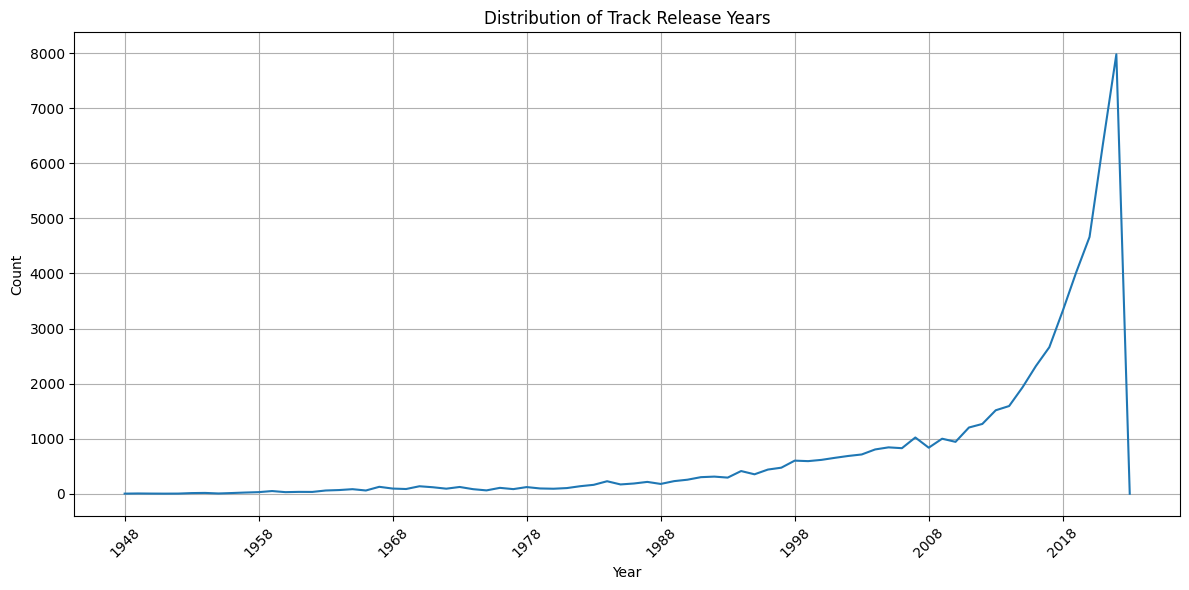

In [ ]:
no_unknown_year_mask = merged_df['album_year'] != 'unknown'
by_year_count_df = merged_df['album_year'][no_unknown_year_mask].value_counts()
display(by_year_count_df.head())
by_year_count_df.sort_index().plot(
    kind='line',
    figsize=(12, 6),
    title='Distribution of Track Release Years'
)
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Seems like 2022 has the most rows and 2023 almost has none. This makes sense because the dataset was created around 2 years ago.

Looking at the chart right now, it seems like the bins are heavily skewed toward 2022. This means if we analyze the data based on the published year, the result will be biased.

However, for the sake of the assignment, let's assume that the data are evenly distributed, especially for the modeling step

### Transform `valence`

Group data into human-readable sentiment categories based on `valence` column and an arbitrary heuristic criteria

As mentioned in the description, `valence` is a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)

First, let's analyze the column to see how we can effectively divide the columns into bins

In [ ]:
def draw_valence_distribution():
  plt.figure(figsize=(10, 6))
  plt.hist(merged_df['valence'].dropna(), bins=30, color='skyblue', edgecolor='black')
  plt.title('Distribution of Valence')
  plt.xlabel('Valence (0 = sad, 1 = happy)')
  plt.ylabel('Number of Tracks')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

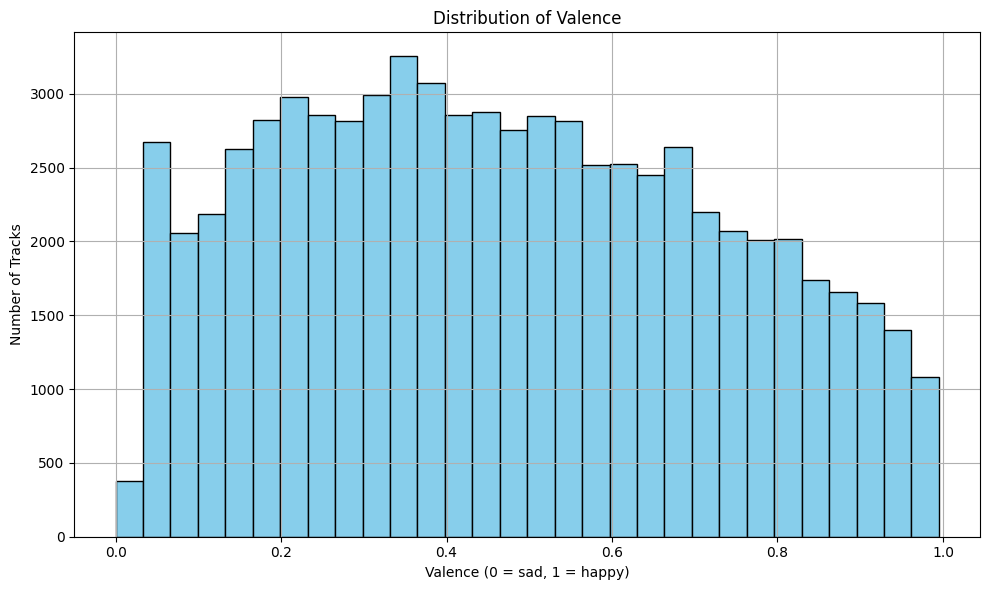

In [ ]:
draw_valence_distribution()

With the exception of the first bin, generally the valence values are evenly distributed. Because of that, we can safely categorize this into 3 categories without worrying being biased

- `sad` for `0 < valence < 0.33`
- `neutral` for `0.33 <= valence < 0.66`
- `happy` for `0.66 <= valence < 1`

In [ ]:
def categorize_valence(v):
    if pd.isna(v):
        return 'unknown'
    if v < 0.33:
        return 'sad'
    elif v < 0.66:
        return 'neutral'
    else:
        return 'happy'

merged_df['valence_category'] = merged_df['valence'].apply(categorize_valence)

Let's view the distribution of the categories

In [ ]:
def draw_valence_category_distribution():
  valence_count_df = merged_df['valence_category'].value_counts().reset_index()
  display(valence_count_df)
  print("\n\n")

  x = valence_count_df["valence_category"]
  y = valence_count_df["count"]

  plt.figure(figsize=(8,4))
  plt.bar(x, y)

  plt.xlabel('Valence Category')
  plt.ylabel('Number of Tracks')
  plt.tight_layout()
  plt.show()

,valence_category,count
0,neutral,27812
1,sad,24194
2,happy,18727


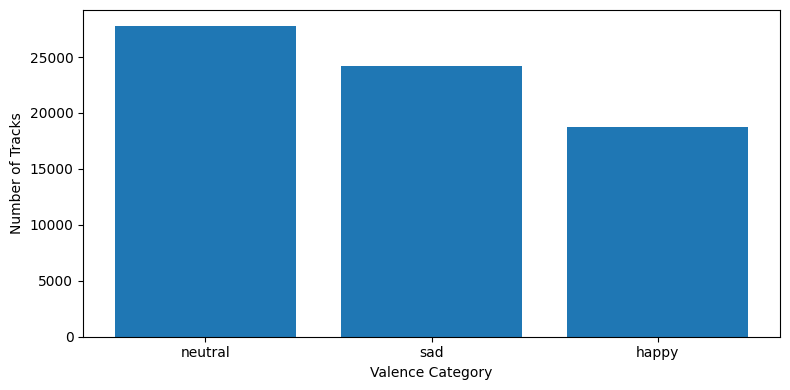

In [ ]:
draw_valence_category_distribution()

Seems like we can... somewhat have a conclusion here, but let's not get ahead of ourselves 🤫

### Transform `language`

The language column is in an array of string, e.g.: ["en"]. The target of this section is to  just take the single value and transform it into readable values

In [ ]:
def get_language_name(lang_code_str: str):
    try:
        # Safely evaluate the string representation of the list
        lang_list = ast.literal_eval(lang_code_str)
        if isinstance(lang_list, list) and len(lang_list) > 0:
            lang_code = lang_list[0]
            # Use pycountry to get the language name
            lang = pycountry.languages.get(alpha_2=lang_code)
            if lang:
                return lang.name
            else:
                return lang_code
        else:
            return lang_code
    except (ValueError, SyntaxError, TypeError):
        return 'unknown'

print("Raw language code")
display(merged_df['language'].value_counts())

merged_df['language_name'] = merged_df['language'].apply(get_language_name)
print("\nTransformed and readable language name")
display(merged_df['language_name'].value_counts())

Raw language code


,count
language,
['en'],28178
['zxx'],7226
['pt'],5055
['es'],3923
['ja'],2444
...,...
['hbs'],1
['sm'],1
['ki'],1



Transformed and readable language name


,count
language_name,
English,28178
unknown,16872
zxx,7226
Portuguese,5055
Spanish,3923
...,...
hbs,1
Samoan,1
Kikuyu,1


In [ ]:
print("\nSongs without language content (code: zxx)")
no_content_mask = merged_df['language_name'] == 'zxx'
no_content_df = merged_df[no_content_mask]
display(no_content_df.head())

print("\nWe'll explore this more later")


Songs without language content (code: zxx)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,tempo,time_signature,track_genre,uri,album_date,language,playcount,album_year,valence_category,language_name
102,5RO0MNa5hBKIM4OcjygadU,Joseph Sullinger,Chi Mai,Chi Mai,40,188695,False,0.739,0.287,6,...,80.640,4,acoustic,5RO0MNa5hBKIM4OcjygadU,"{'day': 29.0, 'month': 7.0, 'year': 2022.0}",['zxx'],654821.0,2022,neutral,zxx
111,7Ca2CkwSqHyr3eCh8IRdjz,Agustín Amigó;Nylonwings,Mujer con Abanico,Mujer con Abanico,41,156787,False,0.769,0.135,5,...,103.939,4,acoustic,7Ca2CkwSqHyr3eCh8IRdjz,"{'day': 16.0, 'month': 9.0, 'year': 2022.0}",['zxx'],522116.0,2022,neutral,zxx
307,2JI53ZVCxMucM68UpCtZ5C,Wayne Mack,Fake a smile,Fake a smile,57,169600,False,0.731,0.191,0,...,149.910,4,acoustic,2JI53ZVCxMucM68UpCtZ5C,"{'day': 20.0, 'month': 4.0, 'year': 2021.0}",['zxx'],7485388.0,2021,sad,zxx
309,0Bv0qHGKNiwzDtHzXrjmIn,Sungha Jung,Irony,River Flows In You,42,214466,False,0.356,0.230,6,...,129.532,4,acoustic,0Bv0qHGKNiwzDtHzXrjmIn,"{'day': 21.0, 'month': 9.0, 'year': 2011.0}",['zxx'],7625227.0,2011,sad,zxx
487,3YalaPTUkyCYanwIf0l4UN,Eddie Vedder,Into The Wild (Music For The Motion Picture),Toulumne,51,60306,False,0.337,0.287,0,...,107.031,4,acoustic,3YalaPTUkyCYanwIf0l4UN,"{'day': 18.0, 'month': 9.0, 'year': 2007.0}",['zxx'],31366268.0,2007,neutral,zxx



We'll explore this more later


## 4. Data analysis and visualization

This section aims to answer these questions as mentioned in the top section

* What's the distribution of different genre and other interesting columns?
* Is there a correlation between popularity and other columns: play count, tempo, valence?
* Do the most repeated songs fall into a specific mood cluster (grouped by valence)?
* How do moods differ between genres (e.g.: rap vs classical)?
* What's the tempo, liveness, and valence over the year (e.g.: based on genre)?

Let's first look at what columns we currently have. For the definition of each column, we can refer back to [this](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70733 entries, 0 to 70732
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          70733 non-null  object 
 1   artists           70733 non-null  object 
 2   album_name        70733 non-null  object 
 3   track_name        70733 non-null  object 
 4   popularity        70733 non-null  int64  
 5   duration_ms       70733 non-null  int64  
 6   explicit          70733 non-null  bool   
 7   danceability      70733 non-null  float64
 8   energy            70733 non-null  float64
 9   key               70733 non-null  int64  
 10  loudness          70733 non-null  float64
 11  mode              70733 non-null  int64  
 12  speechiness       70733 non-null  float64
 13  acousticness      70733 non-null  float64
 14  instrumentalness  70733 non-null  float64
 15  liveness          70733 non-null  float64
 16  valence           70733 non-null  float6

### Q1. Distribution of different language, genre, energy, and valence

We'll first explore the cultural diversity of the dataset through some preliminary visualizations through some key features that shape the character of each track. Later on, we'll use this metadata to predict listening trends and product patterns.

We'll first define some helpers to draw the graphs as these will be repeated across the attributes

In [ ]:
def get_random_color():
  return list(np.random.random(size=3))

# Just generate a prefilled list of colors for graph consistency
prefilled_colors = [get_random_color() for _ in range(1000)]

In [ ]:
MAX_RADIUS = 0.5
BASE_FONT_SIZE = 60
MIN_FONT_SIZE = 7

# Get the interpolated fontsize based on the radius
def get_fontsize_based_on_radius(radius: int):
  return max((radius / MAX_RADIUS) * BASE_FONT_SIZE, MIN_FONT_SIZE)

# Generate the label for our entries with the count taken into account
def append_count_to_label(label: str, count: int):
    return f"{label} ({count})"

# Draw a bubble graph representation of the dataframe - DF is required to have a "count" and "label" column
def draw_bubble_graph(df: pd.DataFrame, title: str):
    # Create a list of circles and makes sure they have equal distance apart
    circles = circlify.circlify(
        df['count'].tolist(),
        # plt will only show 1 quadrant so we need to shift everything to the middle
        # and ensure the biggest circle won't expand more than the boundary (aka r=0.5)
        target_enclosure=circlify.Circle(x=0.5, y=0.5, r=MAX_RADIUS)
    )

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis('off')
    ax.set_aspect('equal')

    for index, (circle, row) in enumerate(zip(circles, df.sort_values(by="count").itertuples())):
        x, y, r = circle.x, circle.y, circle.r
        ax.add_patch(plt.Circle((x, y), r, alpha=0.6, color=prefilled_colors[index]))
        ax.text(x, y, row.label, ha='center', va='center', fontsize=get_fontsize_based_on_radius(r))

    plt.title(title, fontsize=14)
    plt.show()

'''
  Draw a bubble graph representation of the dataframe - DF is required to have a "count" and "label" column
  Pass in the `rest_threshhold` to group all the minority into the `rest` group to avoid noisy graph
'''
def group_and_draw_bubble_graph(df: pd.DataFrame,
                                title: str, group_column_name: str, x_label: str,
                                rest_threshhold: int = 500, draw_bar = True):
  grouped_raw = df[group_column_name].value_counts().sort_values()
  grouped_raw = grouped_raw.reset_index()
  grouped_raw['label'] = grouped_raw.apply(lambda row: append_count_to_label(row[group_column_name], row['count']), axis=1)

  # Separate large and small groups
  major = grouped_raw[grouped_raw['count'] >= rest_threshhold]
  minor = grouped_raw[grouped_raw['count'] < rest_threshhold]

  # Create a new row for "the rest"
  the_rest_count = minor['count'].sum()
  rest_row = pd.DataFrame([{
      'label': append_count_to_label('The Rest', the_rest_count),
      'count': the_rest_count
  }])

  grouped = pd.concat([major, rest_row], ignore_index=True)

  draw_bubble_graph(grouped, title)

  if draw_bar:
    print("\n\n")
    x = grouped["label"]
    y = grouped["count"]

    plt.figure(figsize=(8,4))

    plt.bar(x, y)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel("Count")
    plt.xticks(rotation=45)

    plt.show()

#### Language distribution

Let's first take a look at the language

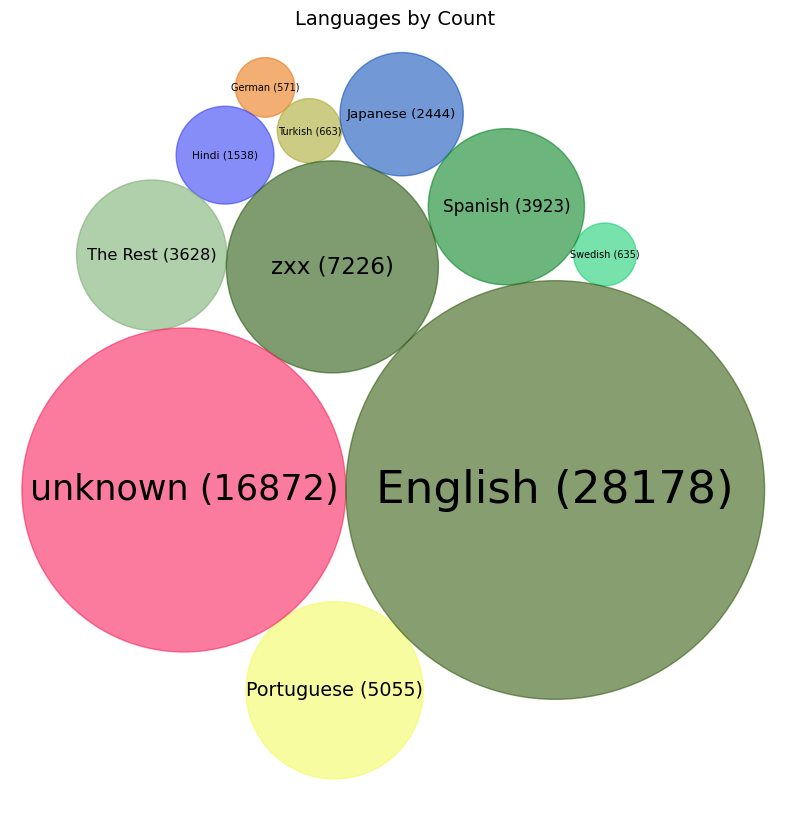

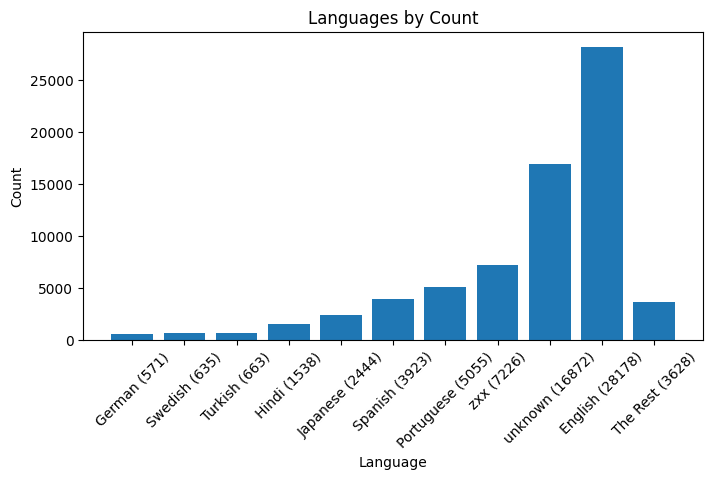

In [ ]:
group_and_draw_bubble_graph(df=merged_df, title="Languages by Count", group_column_name="language_name", x_label="Language")

The dataset seems to lean toward heavily to English. However, there are a lot of songs without language data. This is different from song without words where the language code is `zxx`

#### Genre distribution

Let's next look at genre next

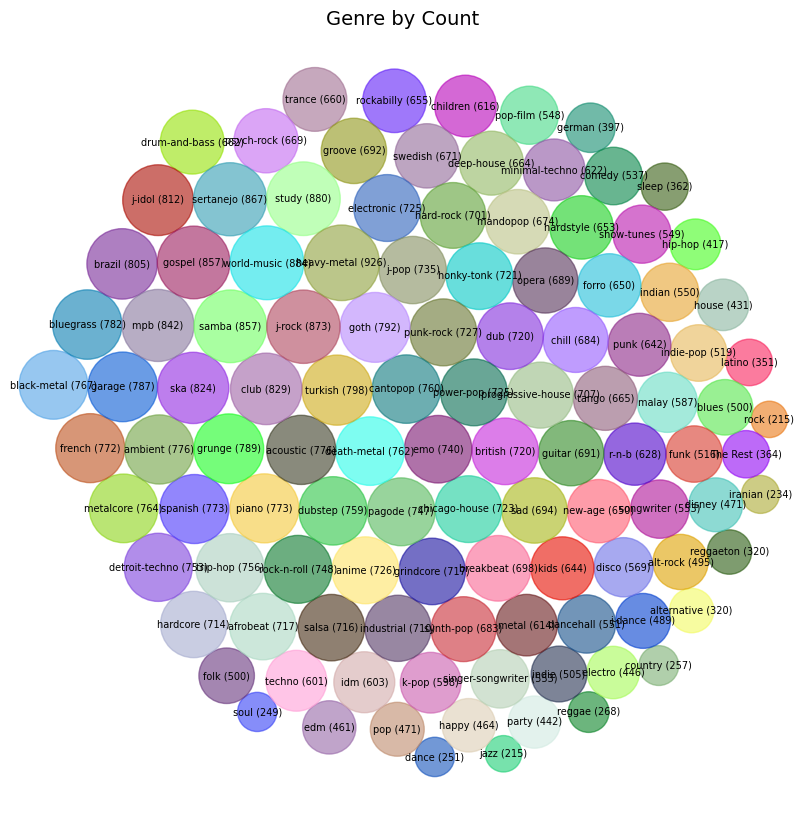

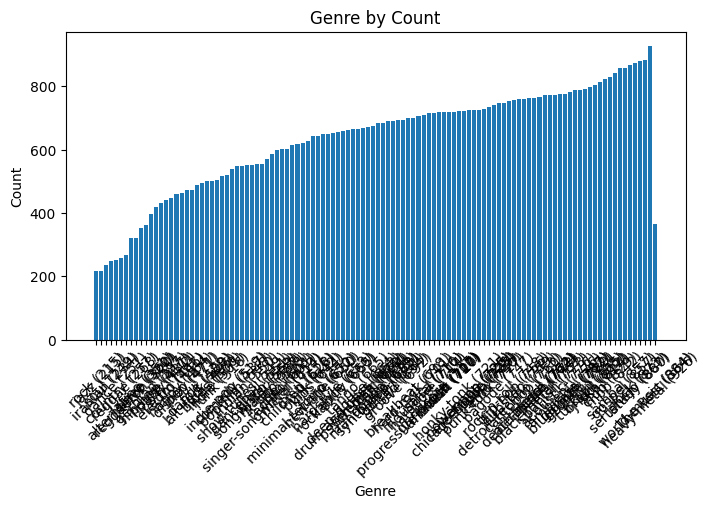

In [ ]:
genre_key="track_genre"
group_and_draw_bubble_graph(df=merged_df, title="Genre by Count", group_column_name=genre_key, x_label="Genre", rest_threshhold=200)

Well... that's certainly isn't helpful at all. At first glance, it seems like the genres are well distributed, however, the bar graph proves otherwise. Let's look at some value count

In [ ]:
merged_df[genre_key].value_counts()

,count
track_genre,
heavy-metal,926
world-music,884
study,880
j-rock,873
sertanejo,867
...,...
rock,215
jazz,215
classical,141


#### Energy distribution

`energy`: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale

In [ ]:
def draw_histogram(df: pd.DataFrame, title: str, x_label: str, y_label: str):
  plt.figure(figsize=(5, 5))
  plt.hist(df, bins=30, color='skyblue', edgecolor='black')
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

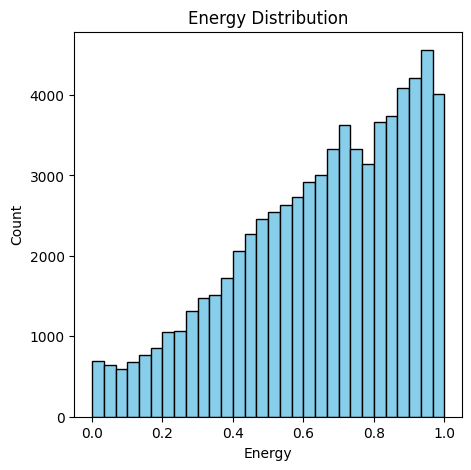

In [ ]:
draw_histogram(df=merged_df['energy'], title="Energy Distribution", x_label="Energy", y_label="Count")

#### Valance distribution

`valence`: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)

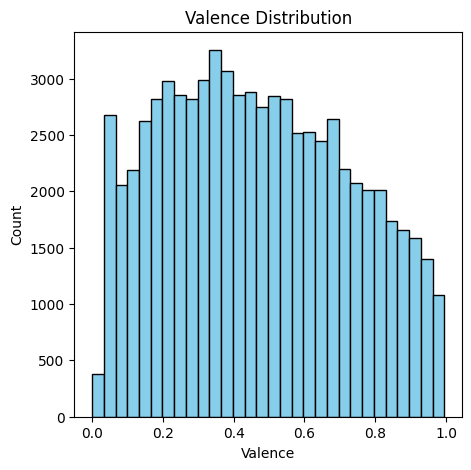

In [ ]:
draw_histogram(df=merged_df['valence'], title="Valence Distribution", x_label="Valence", y_label="Count")

This lines up with the category grouping we saw earlier in the notebook

,valence_category,count
0,neutral,27812
1,sad,24194
2,happy,18727


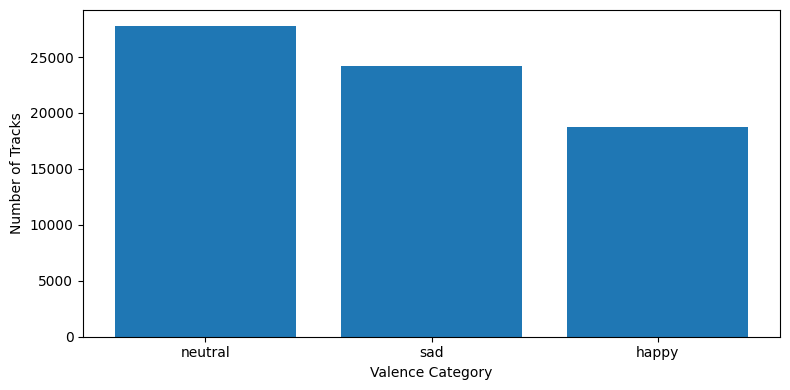

In [ ]:
draw_valence_category_distribution()

### Q2. Popularity and other column correlations

We'll take a look at whether there is any correlation between the popularity columns and the play count as well as the tempo columns

As a reminder, we'll use the Pearson correlation matrix, where:
* `1.0` = perfect positive correlation
* `-1.0` = perfect negative correlation
* `0.0` = no linear correlation

In [ ]:
correlation = merged_df[["tempo", "playcount", "valence", "popularity"]].corr()
display(correlation)

,tempo,playcount,valence,popularity
tempo,1.000000,-0.022955,0.074017,-0.023769
playcount,-0.022955,1.000000,0.040055,0.499470
valence,0.074017,0.040055,1.000000,0.019365
popularity,-0.023769,0.499470,0.019365,1.000000


And in term of visualization

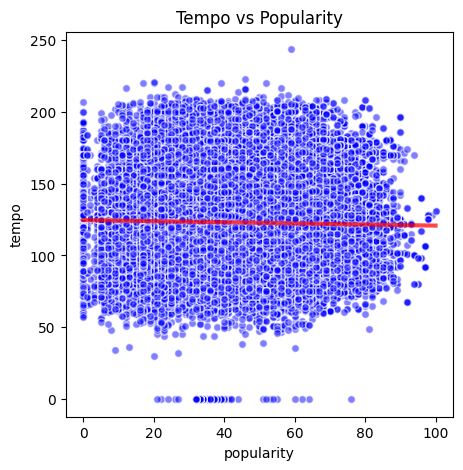

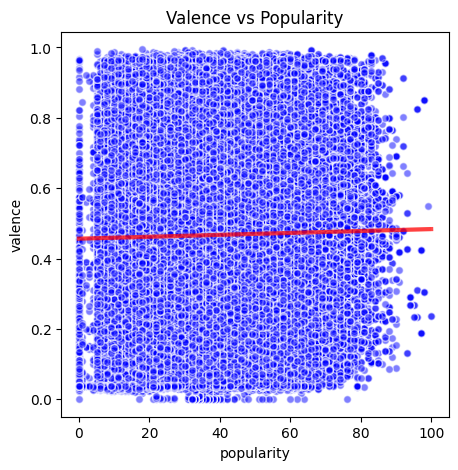

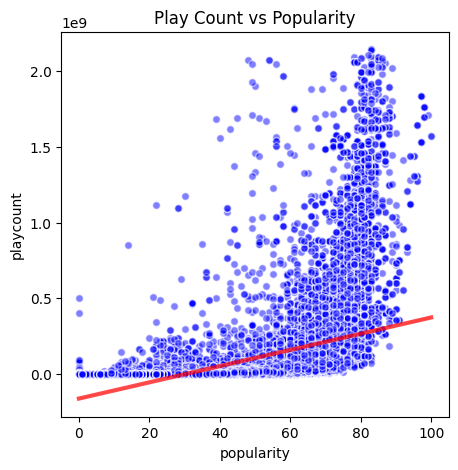

In [ ]:
def draw_regplot(df: pd.DataFrame, x_col: str, y_col: str, title: str):
  plt.figure(figsize=(5, 5))
  sns.regplot(data=df, x=x_col, y=y_col,
              scatter_kws={"alpha": 0.5, "s": 30, "color": 'blue', "edgecolors": 'white'},
              line_kws={"alpha": 0.7, "color": 'red', "linewidth": 3})
  plt.title(title)
  plt.show()

draw_regplot(merged_df, "popularity", "tempo", "Tempo vs Popularity")
draw_regplot(merged_df, "popularity", "valence", "Valence vs Popularity")
draw_regplot(merged_df, "popularity", "playcount", "Play Count vs Popularity")


### Q3. Do the most repeated songs fall into a specific mood cluster (grouped by valence)?

We can simply do a groupby by mood and take the average

,playcount
valence_category,
happy,6.309306e+07
neutral,6.946508e+07
sad,4.826503e+07


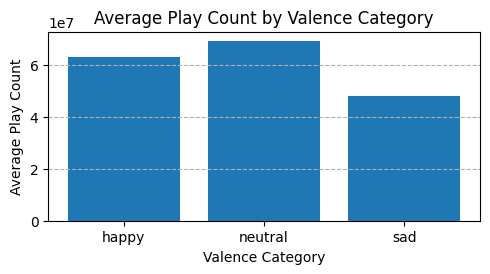

In [ ]:
def draw_bar_graph(x: pd.Series, y: pd.Series, title: str, x_label: str, y_label: str):
  # Draw Figure
  plt.figure(figsize=(5,3))
  # Draw Plot
  plt.bar(x, y)

  # Customize
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.grid(axis="y", linestyle="--")
  plt.tight_layout()

  plt.show()

valence_category_group = merged_df.groupby("valence_category")
playcount_mean = valence_category_group["playcount"].mean()
display(playcount_mean)
draw_bar_graph(playcount_mean.index, playcount_mean.values, "Average Play Count by Valence Category", "Valence Category", "Average Play Count")

Seems like even though there are more sad songs in our data, the happy songs are more played. Let's also verify that via the popularity column

,popularity
valence_category,
happy,40.808619
neutral,42.982274
sad,40.569480


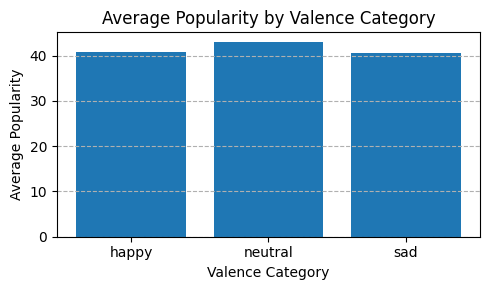

In [ ]:
popularity_mean = valence_category_group["popularity"].mean()
display(popularity_mean)
draw_bar_graph(popularity_mean.index, popularity_mean.values, "Average Popularity by Valence Category", "Valence Category", "Average Popularity")

### Q4. How do moods differ between genres (e.g.: rap vs classical)?

This is similar to the above question, however, we now group by valence then take the genre that appear the most for each valence category. Double group by!

In [ ]:
valence_genre_group = merged_df.groupby(["valence_category", "track_genre"])
valence_genre_count = valence_genre_group.size()
valence_genre_count

valence_category  track_genre
happy             acoustic       144
                  afrobeat       448
                  alt-rock       142
                  alternative     67
                  ambient          8
                                ... 
sad               techno         367
                  trance         455
                  trip-hop       254
                  turkish        233
                  world-music    642
Length: 340, dtype: int64

Let's next figure out what the genre appears the most in each group!

In [ ]:
valence_genre_count = valence_genre_count.reset_index(name='count')
top_genres = valence_genre_count.loc[valence_genre_count.groupby('valence_category')['count'].idxmax()]
top_genres

,valence_category,track_genre,count
94,happy,salsa,614
162,neutral,heavy-metal,501
230,sad,ambient,693


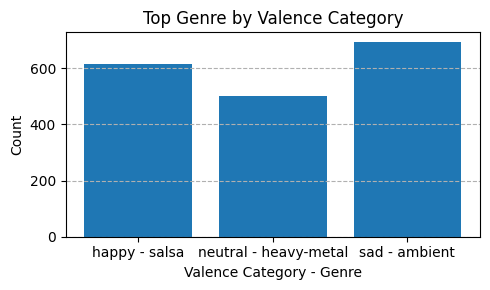

In [ ]:
# Combine the groupby indices into a single x-axis label
x = top_genres['valence_category'] + " - " + top_genres['track_genre']
y = top_genres['count']

draw_bar_graph(x, y, "Top Genre by Valence Category", "Valence Category - Genre", "Count")

Notice how the count distribution are different here for each category compared to the other graphs. This can mean songs in `neutral` are distributed in more genres compared to other valence categories

Interesting how most `sad` song are `ambient`. Rainy sad songs in our edgy teenage era anyone❓

### Q5. What's the tempo, liveness, and valence over the year (e.g.: based on genre)?

Let's see if there is a trend over time for those columns!

In [ ]:
def draw_line_graph(x: pd.Series, y: pd.Series, title: str, x_label: str, y_label: str, ax=None):
  if ax is None:
      fig, ax = plt.subplots(figsize=(6, 3))
  ax.plot(x, y)
  ax.set_title(title)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  ax.grid(True)

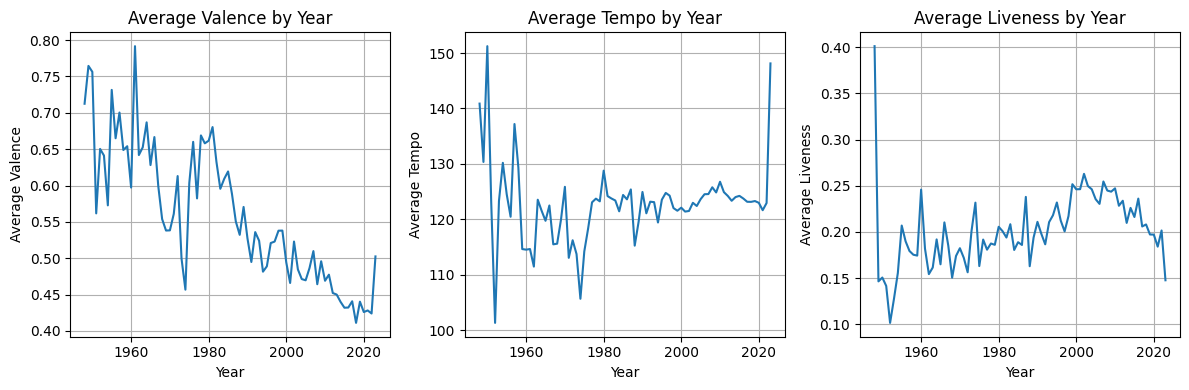

In [ ]:
# We have some `unknown` year, so let's first get rid of that
valid_year_mask = merged_df['album_year'] != 'unknown'
valid_year_df = merged_df[valid_year_mask]
year_group = valid_year_df.groupby("album_year")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 2 columns

valence_over_year_mean = year_group["valence"].mean()
draw_line_graph(valence_over_year_mean.index, valence_over_year_mean.values, "Average Valence by Year", "Year", "Average Valence", ax=axes[0])

tempo_over_year_mean = year_group["tempo"].mean()
draw_line_graph(tempo_over_year_mean.index, tempo_over_year_mean.values, "Average Tempo by Year", "Year", "Average Tempo", ax=axes[1])

liveness_over_year_mean = year_group["liveness"].mean()
draw_line_graph(liveness_over_year_mean.index, liveness_over_year_mean.values, "Average Liveness by Year", "Year", "Average Liveness", ax=axes[2])

plt.tight_layout()
plt.show()

Seems like `valence` has some correlation with `year`, let's verify it using another reg plot

,album_year,valence
album_year,1.000000,-0.845295
valence,-0.845295,1.000000


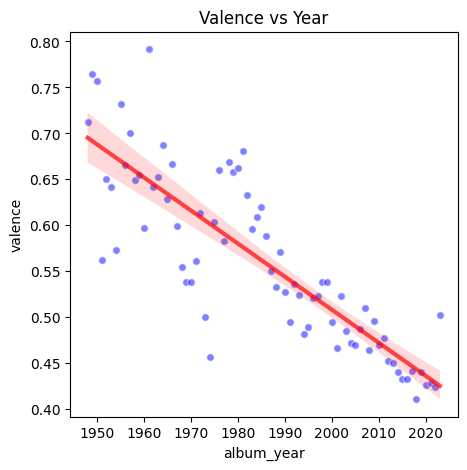

In [ ]:
valence_year_correlation = valence_over_year_mean.reset_index()
valence_year_correlation.columns = ['album_year', 'valence']
display(valence_year_correlation.corr())

draw_regplot(df=valence_year_correlation, x_col="album_year", y_col="valence", title="Valence vs Year")

And voila 🔊 There ya go, seems like the songs are getting sadder by year!

## 5. Conclusion and Future Work

### Conclusion

In this project, we explored one of the huge dataset of Spotify tracks. We merge the metadata (such as genre, language, and release date) with audio features (like valence, tempo, and popularity)

Through various visualizations, we uncovered key patterns:
* The dataset is distributed pretty well between genres, but seems to be focused on English rather than other languages
* The dataset also seems to have more intense songs rather than low energy songs
* Valence (musical "positivity") had varying associations with popularity and genre.
* Valance and tempo don't seem to be very correlated with popularity
* Songs are getting sadder over the years


### Future Work

For future work, I'd love to
* Build a regression or classification model to predict popularity based on audio and metadata features.
* Build some kind of graph network for relationship to make a Shazam clone